<a href="https://colab.research.google.com/github/utkarshminhas/violence-detection-fyp/blob/main/notebooks/jpg_to_tfds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from tqdm import tqdm
import numpy as np
import tensorflow as tf
import random
from glob import glob

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
processed_dir = '/content/drive/Shareddrives/Datasets/Raw RWF-2000 (without_mog)'
print(len(os.listdir(processed_dir)))
print(len(os.listdir(processed_dir+"/Fight")))
print(len(os.listdir(processed_dir+'/NonFight')))

2
1000
1000


In [4]:
image_size = (299, 299)

# label_to_int = {
#     'Fight': [1,0],
#     'NonFight': [0,1]
# }

# fight = label_to_int.get('Fight')
# nonfight = label_to_int.get('NonFight')

nonFight, fight = ([0, 1], [1, 0])

In [5]:
# def load_initial_data():
#     labels = []
#     allImages = sorted(glob(os.path.join(processed_dir, "*/*/*.*")))
#     for name in allImages: 
#         # print(name)
#         if name.find('NonFight') != -1:
#             labels.append(nonFight)
#         else:
#             labels.append(fight)
#     return allImages, labels

In [6]:
def load_initial_data():
    x = []
    y = []

    # Fights
    allFights = sorted(glob(os.path.join(processed_dir, 'Fight/*')))
    x.extend(allFights)
    y.extend([fight] * len(allFights))

    # Non Fights
    allNonFights = sorted(glob(os.path.join(processed_dir, 'NonFight/*')))
    x.extend(allNonFights)
    y.extend([nonFight] * len(allNonFights))

    return x, y

In [7]:
videoPaths, labels = load_initial_data()

In [8]:
# s = imagePaths[0].split('/')
# video_name = s[7]
# current_label = ''
# for i in imagePaths:
#     global current_label
#     l = i.split('/')
#     if l[6] != current_label:
#         current_label = l[6]
#         print('Starting Index:', imagePaths.index(i), current_label)
#     if l[7] != video_name:
#         video_name = l[7]
#         # print(video_name)

In [9]:
# print(f"Images: {len(imagePaths)} - Labels: {len(labels)}",end="\n\n")

# isFight = [i for i, x in enumerate(labels) if x == fight]

# print("Fight Images ->",isFight[0],isFight[-1],len(isFight))
# print(imagePaths[0])
# print(imagePaths[29999],end="\n\n")

# print("NonFight")
# print(imagePaths[30000])
# print(imagePaths[-1])

In [10]:
def get_image(imagePath):
    img = cv2.imread(imagePath, cv2.IMREAD_COLOR) # Read in RGB  directly
    img = cv2.resize(img, image_size)
    img = img / 255.0
    img = img.astype(np.float32)
    return img

In [11]:
def preprocess(videoPath, label):
    def myFunction(videoPath):
        videoPath = videoPath.decode()
        frames = []
        for frame_path in glob(os.path.join(videoPath, '*')):
            image = get_image(frame_path)
            frames.append(image)
        return np.asarray(frames)
    video = tf.numpy_function(myFunction, [videoPath], [tf.float32])[0]
    print(video.shape)
    return video, label

In [12]:
def tf_dataset(videoPaths, labels, batch_size=5):
    dataset = tf.data.Dataset.from_tensor_slices((videoPaths, labels))
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch_size)
    return dataset

In [13]:
# %load_ext autotime

In [14]:
dataset = tf_dataset(videoPaths, labels, batch_size=2)

<unknown>


In [15]:
# dataset.__len__()
print(len(dataset))

1000


One Batch is: (2, 30, 299, 299, 3) (2, 2)
One video is: (30, 299, 299, 3) (2,)

One image is: (299, 299, 3) (2,)

[1 0]


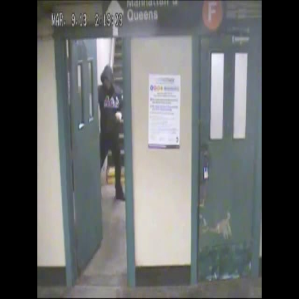

In [16]:
for x, y in dataset:
    x = x.numpy()
    y = y.numpy()
    print("One Batch is:", x.shape, y.shape)
    x = x[0] 
    y = y[0]
    print("One video is:", x.shape, y.shape, end="\n\n")
    x = x[0] 
    # y = y[0]
    print("One image is:", x.shape, y.shape, end="\n\n")
    x *= 255
    print(y)
    cv2_imshow(x)
    break

In [17]:
# Shuffle
dataset.shuffle(40, reshuffle_each_iteration=True)

dataset_size = int(len(dataset) * 0.8)

# total video = 2000
# batch size = 5
# total batches = 400
# total batches

train_dataset = dataset.take(dataset_size) 
test_dataset = dataset.skip(dataset_size)

In [18]:
for _, y in train_dataset:
    y = y.numpy()
    # print("One Batch is:", y.shape)
    y = y[0]
    # print("One video is:", y.shape, end="\n\n")
    print(y)
    break

[1 0]


In [19]:
!pip install tensorflow_addons

In [20]:
from tensorflow.keras import layers
import numpy as np
from keras.layers import TimeDistributed, Conv2D, Dense, MaxPooling2D, \
Flatten, LSTM, Dropout, BatchNormalization
from keras import models
import itertools

import keras
from keras import optimizers
# import tensorflow_addons as tfa

import datetime

In [21]:
input_shape = (30, image_size[0], image_size[1], 3)
num_epochs = 5
print(input_shape)

(30, 299, 299, 3)


In [22]:
# strategy= tf.distribute.MultiWorkerMirroredStrategy()

# with strategy.scope():
model = models.Sequential(
    [
        TimeDistributed(
            Conv2D(32, (3, 3), activation=tf.nn.relu), 
            input_shape=input_shape
        ),
        TimeDistributed(MaxPooling2D((2, 2), strides=(1, 1))),
        TimeDistributed(Conv2D(32, (4, 4), activation=tf.nn.relu)),
        TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))),
        TimeDistributed(Conv2D(32, (4, 4), activation=tf.nn.relu)),
        TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))),
        TimeDistributed(Flatten()),
        Dropout(0.6),
        LSTM(256, return_sequences=False, dropout=0.5, input_shape=input_shape),
        Dropout(0.7),
        Flatten(),
        Dense(64, activation=tf.nn.relu),
        Dense(32, activation=tf.nn.relu),
        Dense(2, activation=tf.nn.softmax)
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 30, 297, 297, 32)  896       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 296, 296, 32)  0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 293, 293, 32)  16416     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 146, 146, 32)  0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 143, 143, 32)  16416     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 71, 71, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 161312)        0

In [23]:
# tqdm_callback = tfa.callbacks.TQDMProgressBar()
# model_path = 'cnn_lstm_model.h5'
# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

callbacks_list = [
    # tqdm_callback,
    # keras.callbacks.EarlyStopping(monitor=['acc'], patience=3),
    # keras.callbacks.ModelCheckpoint(
    #     filepath=model_path,
    #     monitor='val_loss',
    #     save_best_only=True
    # ),
    # tensorboard_callback,
    # keras.callbacks.ReduceLROnPlateau(
    #     monitor="val_loss",
    #     factor=0.1,
    #     patience=3
    # )
]

optimizer = optimizers.Adam()

model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

In [ ]:
# with tf.device('/device:GPU:0'):
history = model.fit(
    train_dataset,
    epochs=num_epochs,
    steps_per_epoch=len(dataset) / num_epochs,
    validation_data=test_dataset,
    validation_steps=len(dataset) / num_epochs,
    verbose=2
)

Epoch 1/5


In [ ]:
def myGen():
  for x,y in dataset:
    yield x.numpy(),y.numpy()[0]

In [ ]:
x,y=next(myGen())
print(x.shape,"  ",y.shape)
print(y)

In [ ]:
ds = tf.data.Dataset.from_generator(myGen,output_signature = (tf.TensorSpec(shape=x.shape, dtype=tf.float32),tf.TensorSpec(shape=y.shape, dtype=tf.int32),))

In [ ]:
batch_size=4 # creates a batch of 4 videos
ds=ds.batch(batch_size)

In [ ]:
for x,y in ds:
  x=x.numpy()
  y=y.numpy()
  print(x.shape,y.shape)
  break

In [ ]:
# We can either use ds to fit the model
# or we can optimize the "dataset" above to give out the "batch_size" videos at once 